In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as pl
import xarray as xr
from scipy.integrate import odeint
import regionmask
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import scipy.stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table 
import time
import warnings
import seaborn as sns
from sklearn.metrics import r2_score#print(r2_score(y3,y3_fitted))
import xlrd
import random
####     ax.set_extent([-15, 45, 28, 76], crs=ccrs.PlateCarree())
from sklearn import preprocessing
robust = preprocessing.RobustScaler()
warnings.filterwarnings('ignore')
from matplotlib import cm
from matplotlib.colors import ListedColormap
from cartopy.util import add_cyclic_point


In [ ]:
################
##### Load Data
#################
tp_=np.load('tp_year.npy')

#################
#### Calculate the trend of TPSI
##################
trend_tp=np.zeros((2,181,360))
for lat in range(0,181):
    for lon in range(0,360):
    y1=tp_[:,lat,lon]
    x1=np.arange(0,70)
    x1=sm.add_constant(x1)
    model1 = sm.OLS(y1,x1)
    res1 = model1.fit()
    trend_tp[0,lat,lon]=res1.params[1]
    trend_tp[1,lat,lon]=res1.pvalues[1]

    

##########################
##### Create new colormap
#########################
import numpy as np

import cmaps 

import matplotlib.pyplot as plt

import matplotlib as mpl   

from matplotlib.colors import ListedColormap 
#######################生成画板#####################################
fig=plt.figure(figsize=(10,8),dpi=150)

ax1=fig.add_axes([0,0,1,0.05])                                                 
ax2=fig.add_axes([0,0.25,1,0.05])  
#######################定义新的colormap#########################################
norm =mpl.colors.Normalize(vmin=-0.48, vmax=0.48)   
cmap=cmaps.BlueWhiteOrangeRed  
newcolors=cmap(np.linspace(0,1,12))
newcmap=ListedColormap(newcolors[::1]) 
###########################################################################        
fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap='BlueWhiteOrangeRed'),              
                 cax=ax1,                                                      
                 orientation='horizontal',    label='old cmap' ,
ticks=[-0.4,-0.32,-0.24,-0.16,-0.08,0,0.08,0.16,0.24,0.32,0.4]     ,                                                    
                 extend='both')                 

fc2=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=newcmap),                                            
                  cax=ax2,         format='%.2g'    ,                                             
                  orientation='horizontal',     label='new cmap' ,
ticks=[-0.4,-0.32,-0.24,-0.16,-0.08,0,0.08,0.16,0.24,0.32,0.4]     ,                                     
                  extend='both')  
fc2.ax.tick_params(which='major',direction='in',length=29)


##############
##### Fig1.a
#############
tp_20=np.nanmean(tp_[-20:,:],axis=0)
tp_20[600:]=np.nan

fig = plt.figure(figsize=(20,20))


levels=np.arange(-0.5,0.6,0.1)


ax=fig.add_subplot(2, 2, 1, projection=ccrs.EckertIII())
ax.set_global()
data_draw, data_lon = add_cyclic_point(tp_20, coord=data.lon)
data_LON, data_LAT = np.meshgrid(data_lon, data.lat)
filled_c = ax.contourf(data_LON, data_LAT, data_draw,transform=ccrs.PlateCarree(),cmap=newcmap,extend='both',levels=levels)
fig.colorbar(filled_c, orientation='horizontal')
ax.coastlines(linewidth=1.7)

ar6_land=regionmask.defined_regions.srex
line_kws  = dict(
    lw=1.7,linestyle='--')
ax = ar6_land.plot(ax=ax,label="abbrev", line_kws=line_kws,add_label=False,add_coastlines=True) 

#################
##### Fig1.b
#################
tp_trend_all_sig=trend_tp[1,:,:]## pvalues
tp_trend_all_sig[600:,:]=np.nan##### ###Antarctica excluded
tp_trend_all_sig[tp_trend_all_sig>0.05]=np.nan### Sig
tp_trend_all_sig[tp_trend_all_sig<0.05]=999
tp_trend_all_sig[tp_trend_all_sig==999]=1
from cartopy.util import add_cyclic_point
fig = plt.figure(figsize=(20,20))


levels=np.arange(0,0.21,0.05)


ax=fig.add_subplot(2, 2, 1, projection=ccrs.EckertIII())
ax.set_global()
data_draw, data_lon = add_cyclic_point(trend_tp[0,0,:,:]*10, coord=data.lon)###per decade
data_LON, data_LAT = np.meshgrid(data_lon, data.lat)
filled_c = ax.contourf(data_LON, data_LAT, data_draw,transform=ccrs.PlateCarree(),cmap='Oranges',extend='both',levels=levels)
c1b = ax.contourf(data.lon,data.lat, tp_trend_all_sig, zorder=1,hatches=['..', None],colors="none", transform=ccrs.PlateCarree())
fig.colorbar(filled_c, orientation='horizontal')
ax.coastlines(linewidth=1.7)

ar6_land=regionmask.defined_regions.srex
line_kws  = dict(
    lw=1.7,linestyle='--')
ax = ar6_land.plot(ax=ax,label="abbrev", line_kws=line_kws,add_label=False,add_coastlines=True) 

##############
### Fig1.c
#############

###### Calculate TPSI of Regions
data_tp = tp_
latitude = data.lat
longitude=data.lon
times = np.arange(1951,2021)
tp_arr = xr.DataArray(data_tp, coords=[times, latitude,longitude], dims=['time', 'latitude','longitude'])

mask = regionmask.defined_regions.srex.mask(longitude,latitude)### mask SREX regions
mask_27=np.zeros((27,720,1440))
for i in range(1,27):
    mask_temp=mask==i
    mask_27[i,:]=mask_temp+0
mask_27[mask_27==0]=np.nan


tp_region=np.zeros((27,70))
for i in range(1,27):
    print(i)
    tp_region[i,:]=np.nanmean(np.nanmean(tp_arr*mask_27[i,:],axis=1),axis=1)
    
    
###### Calculate the trend of Regions' Tpsi

trend_region=np.zeros((27,2))
for i in range(1,27):
    y1=tp_region[i,:]
    x1=np.arange(0,70)
    x1=sm.add_constant(x1)
    model1 = sm.OLS(y1,x1)
    res1 = model1.fit()
    res1.summary()
    y1_fitted = res1.fittedvalues
    trend_region[i,0]=res1.params[1]
    trend_region[i,1]=res1.pvalues[1]

    
    
#### set the color by the trend 
sig_region=trend_region[:,1].copy()
for i in range(1,27):
    if sig_region[i]<0.001:
        sig_region[i]=9999
    elif sig_region[i]>0.001 and sig_region[i]<0.01:
        sig_region[i]=8888
    elif sig_region[i]>0.01 and sig_region[i]<0.05:
        sig_region[i]=7777
        
sig_region[sig_region<100]=np.nan
sig_region[sig_region==7777]=1
sig_region[sig_region==8888]=2
sig_region[sig_region==9999]=3


        
tp_region_color=tp_region_state.copy()
for i in range(1,27):
    value = tp_region_color[i]
    if value >= 0.4:
        tp_region_color[i]= 4
    elif 0.3 <= value < 0.4:
        tp_region_color[i]= 3
    elif 0.2 <= value < 0.3:
        tp_region_color[i]= 2
    elif 0.1 <= value < 0.2:
        tp_region_color[i]= 1
    elif 0 <= value < 0.1:
        tp_region_color[i]= 0
    elif -0.1 < value <= 0:
        tp_region_color[i]= 0
    elif -0.2 < value <= -0.1:
        tp_region_color[i]= -1
    elif -0.3 < value <= -0.2:
        tp_region_color[i]= -2
    elif -0.4 < value <= -0.3:
        tp_region_color[i]= -3
    elif value<=-0.4:
        tp_region_color[i]= -4
        
        
######### Draw

fig = plt.figure(figsize=(5,20))

plt.xlabel('TPSI × 10-2/yr-1 ')
plt.ylabel('Regions')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
sorted_indices = sorted(range(len(trend_region[1:,0])), key=lambda i: trend_region[i+1,0], reverse=True)
sorted_names = [names[i] for i in sorted_indices]

for i in range(26, 0,-1):
    index = sorted_indices[i-1]  # 获取排序后的索引
    plt.barh(sorted_names[i-1], trend_region[index+1, 0]*100, edgecolor='black',color='#921519' 
             if tp_region_color[index+1] == 4 
             else 
             '#d31f28' 
             if tp_region_color[index+1] == 3 
             else 
             '#feb032' 
             if tp_region_color[index+1] == 2 
             else 
             '#fceb9b'
             if tp_region_color[index+1] == 1
             else 
             '#ffffff'
             if tp_region_color[index+1] == 0
             else 
             '#d7eff9'
             if tp_region_color[index+1] == -1 
             else 
             '#9ddaf7'
             if tp_region_color[index+1] == -2 
             else 
             '#2459a7'
             if tp_region_color[index+1] == -3
             else 
             '#1b2c62'            
            )

# 同样地，我们根据排序后的索引来添加星号
for i in range(1, 27):
    index = sorted_indices[i-1]
    max_y = np.nanmax(trend_region[index+1, 0]*100)  # 这里需要根据实际情况调整，可能需要取所有柱子的最大值
    plt.text( max_y, sorted_names[i-1],'***' if sig_region[index+1] == 3 else 
             '**' if sig_region[index+1] == 2 else 
             '*' if sig_region[index+1] == 1 else '')
plt.rcParams['svg.fonttype'] = 'none'


# Fig1.c

In [160]:


fig = plt.figure(figsize=(5,20))

plt.xlabel('TPSI × 10-2/yr-1 ')
plt.ylabel('Regions')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# 现在我们根据排序后的索引来绘制柱状图


In [164]:
trend_tp.shape

(5, 2, 720, 1440)

In [161]:
trend_tp[0,0,600:,:]=np.nan

In [168]:
a=trend_tp[0,0,:,:]*30

In [171]:
np.nanmean(a)

0.1489554660499413

In [187]:
np.nanmax(trend_tp[0,0,:,:])*10

0.1694943497876335

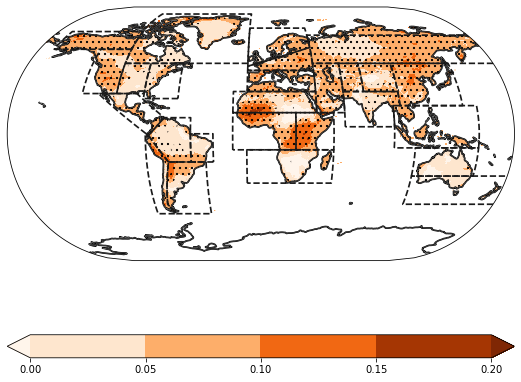

In [192]:
from cartopy.util import add_cyclic_point
fig = plt.figure(figsize=(20,20))


levels=np.arange(0,0.21,0.05)


ax=fig.add_subplot(2, 2, 1, projection=ccrs.EckertIII())
ax.set_global()
data_draw, data_lon = add_cyclic_point(trend_tp[0,0,:,:]*10, coord=data.lon)
data_LON, data_LAT = np.meshgrid(data_lon, data.lat)
filled_c = ax.contourf(data_LON, data_LAT, data_draw,transform=ccrs.PlateCarree(),cmap='Oranges',extend='both',levels=levels)
c1b = ax.contourf(data.lon,data.lat, tp_trend_all_sig, zorder=1,hatches=['..', None],colors="none", transform=ccrs.PlateCarree())
fig.colorbar(filled_c, orientation='horizontal')
ax.coastlines(linewidth=1.7)

ar6_land=regionmask.defined_regions.srex
line_kws  = dict(
    lw=1.7,linestyle='--')
ax = ar6_land.plot(ax=ax,label="abbrev", line_kws=line_kws,add_label=False,add_coastlines=True) 


plt.rcParams['svg.fonttype'] = 'none'
fig.savefig('Fig1_c.pdf')
fig.savefig('Fig1_c.svg')